In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# read data
df = pd.read_excel('data/data_manufacturing.xlsx')

In [6]:
# Get the names of the columns with categorial variables (object data type)
string_col_names = df.dtypes.index[df.dtypes == 'object']

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define the column transformer using a one hot encoder for the columns to transform (string_col_names)
ct = ColumnTransformer(
    transformers=[("encoder", OneHotEncoder(drop="first"), string_col_names)],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [8]:
# Perform the transforamtion on the features
data_transformed = ct.fit_transform(df)
# Show the resulting column names
print(ct.get_feature_names_out())

['API Particle Size_Medium' 'API Particle Size_Small'
 'MgSt Supplier_Smith Ind' 'Lactose Supplier_James Ind'
 'Sugar Supplier_Sweet' 'Talc Supplier_Smooth' 'Compressor_COMPRESS2'
 'Coating Supplier_Down' 'Coating Supplier_Mac' 'Mill Time' 'Screen Size'
 'Blend Time' 'Blend Speed' 'Force' 'Coating Viscosity' 'Inlet Temp'
 'Exhaust Temp' 'Spray Rate' 'Atom. Pressure' 'Dissolution']


In [9]:
df = pd.DataFrame(data_transformed, columns=ct.get_feature_names_out())

In [10]:
# Separate features (first columns) from target (last column)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [13]:
from sklearn.model_selection import train_test_split
# Randomly split the data set in 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234) #4245

In [14]:
from sklearn.preprocessing import StandardScaler
# define scaler object
sc = StandardScaler()
# fit scaler based on training data, scale training data
X_train_sc = sc.fit_transform(X_train)
# scale test data
X_test_sc = sc.transform(X_test)

In [100]:
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

# define epsilon list for tuning logarithmically from 1e-3 to 10
epsilon = np.linspace(1, 5, 50)
results = {}

# Loop for simple hyperparameter tuning of epsilon
for e in epsilon:

    # gerneration of model for current epsilon
    huber = HuberRegressor(epsilon=e, max_iter=10000, alpha=0)
    # scoring for k-folds 
    scores = cross_validate(
        huber, X_train_sc, y_train, cv=3, scoring=("neg_root_mean_squared_error")
    )
    # storing of cross validation results
    results[e] = scores

# scoring for k-folds of OLS for results comparison
score_ols = cross_validate(
    LinearRegression(), X_train_sc, y_train, cv=3, scoring=("neg_root_mean_squared_error")
)

Text(0, 0.5, 'RMSE')

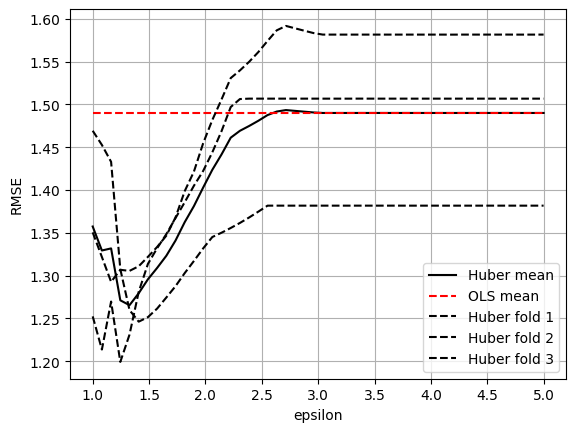

In [101]:
# Huber: mean over all folds over epsilon
plt.plot(
    list(results.keys()),
    [np.mean(results[x]["test_score"]) * -1 for x in results],
    "k",
    label="Huber mean",
)
# OLS: mean over all folds
plt.hlines(
    np.mean(score_ols["test_score"]) * -1,
    min(list(results.keys())),
    max(list(results.keys())),
    linestyles="--",
    colors="r",
    label= "OLS mean"
)
# Huber: all fold over epsilon
plt.plot(
    list(results.keys()),
    [results[x]["test_score"] * -1 for x in results],
    "--k",
    label=["Huber fold 1", "Huber fold 2", "Huber fold 3"],
)


plt.grid()
plt.legend()
plt.xlabel("epsilon")
plt.ylabel("RMSE")

In [102]:
# perform OLS training
ols_reg = LinearRegression().fit(X_train_sc, y_train)
# perfomr Huber regressor training for best epsilon value
huber_reg = HuberRegressor(epsilon=1.3, max_iter=2000, alpha=0).fit(X_train_sc, y_train)

# training prediciton for OLS and Huber
y_pred_test_ols = ols_reg.predict(X_test_sc)
y_pred_test_huber = huber_reg.predict(X_test_sc)

# testing prediciton for OLS and Huber
y_pred_train_ols = ols_reg.predict(X_train_sc)
y_pred_train_huber = huber_reg.predict(X_train_sc)

Text(0.5, 1.0, 'RMSE: Huber: 1.09, OLS: 1.03')

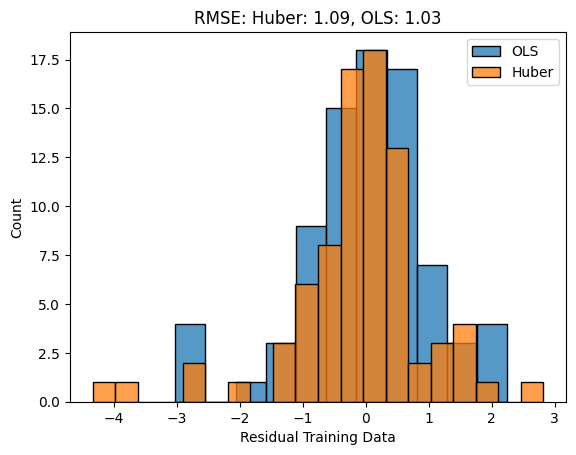

In [103]:
import seaborn as sns
from sklearn.metrics import root_mean_squared_error

# Histogram of training residuals
sns.histplot(data=y_pred_train_ols - y_train, label="OLS")
sns.histplot(data=y_pred_train_huber - y_train, label="Huber")

plt.xlabel("Residual Training Data")
plt.legend()
plt.title(
    f"RMSE: Huber: {root_mean_squared_error(y_train, y_pred_train_huber):.2f}, OLS: {root_mean_squared_error(y_train, y_pred_train_ols):.2f}"
)

Text(0.5, 1.0, 'RMSE: Huber: 0.78, OLS: 0.94')

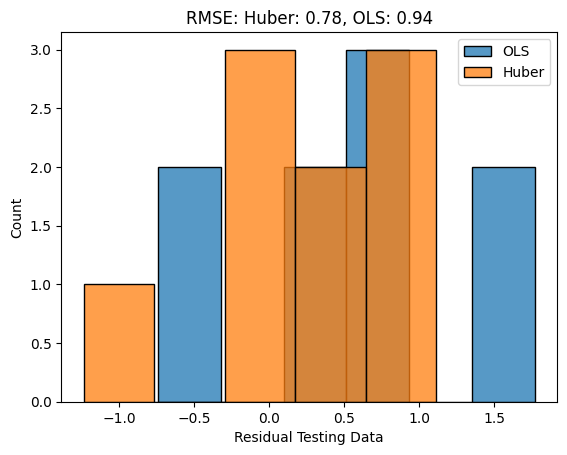

In [104]:
sns.histplot(data=y_pred_test_ols-y_test, label="OLS")
sns.histplot(data=y_pred_test_huber-y_test, label="Huber")

# histogram of testing residuals
plt.xlabel("Residual Testing Data")
plt.legend()
plt.title(
    f"RMSE: Huber: {root_mean_squared_error(y_test, y_pred_test_huber):.2f}, OLS: {root_mean_squared_error(y_test, y_pred_test_ols):.2f}"
)

Text(0, 0.5, 'Measurement')

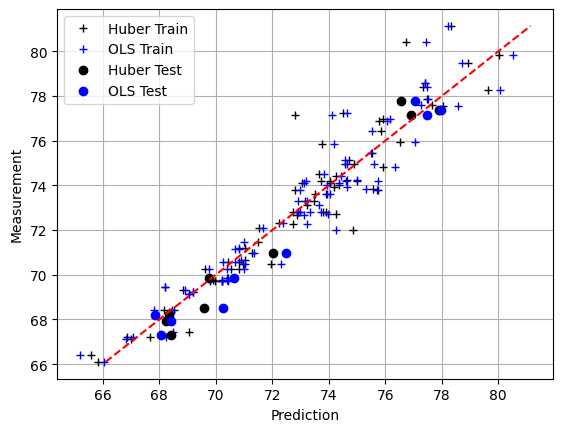

In [105]:
# parity plot of training and testing data for huber regression and OLS
plt.plot(y_pred_train_huber, y_train, "k+", label="Huber Train")
plt.plot(y_pred_train_ols, y_train, "b+", label="OLS Train")

plt.plot(y_pred_test_huber, y_test, "ko", label="Huber Test")
plt.plot(y_pred_test_ols, y_test, "bo", label="OLS Test")

plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], "--r")

plt.grid()
plt.legend()
plt.xlabel("Prediction")
plt.ylabel("Measurement")